# Visualisations for the effect of control interval

In [1]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from cmcrameri import cm

Standard plotting parameters

In [2]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 2   # Default for all spines
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 
plt.rc('axes', unicode_minus=False)


### Helper function to load in data as pandas DataFrame

In [3]:
def load_data_file(step_size: str, n_days: int = 10, control_frequency: int = 1) -> pd.DataFrame:
    '''
    Load a single data file with the results of the simulation
    Arguments:
        step_size: str, step size of the simulation
        n_days: int, number of days of the simulation
        control_frequency: int, control frequency of the simulation
    returns:
        python_variables: pd.DataFrame, data from the simulation
    '''
    python_variables = pd.read_csv(f"../data/model-comparison/python-rule-based/step-size-{step_size}-control-frequency-{control_frequency}-{n_days}.csv", sep=",")[:]
    return python_variables

def load_all_data(step_sizes: List[str], control_frequencies: List[int], n_days: int = 10) -> List[List[pd.DataFrame]]:
    '''
    Load all data from the experiments checking step size and control frequency.
    Arguments:
        step_sizes: List[str], step sizes of the simulation
    returns:
        python_variables: List[pd.DataFrame], data from the simulation
    '''
    experiment_step_size_res = []

    for step in step_sizes:
        python_states = []
        for control_freq in control_frequencies[:]:
            py_states = load_data_file(step, n_days=n_days, control_frequency=control_freq)
            python_states.append(py_states)
        experiment_step_size_res.append(python_states)
    return experiment_step_size_res



In [4]:
matlab_timing = [115.3312, 113.6639, 117.1956, 113.6042, 116.7673, 114.0659, 113.2125, 114.9254, 114.6993, 114.5638]
matlab_timing_mean = np.mean(matlab_timing)
matlab_timing_std = np.std(matlab_timing)

In [5]:
control_frequencies = [2, 4, 8, 16] + [i*30 for i in range(1, 121)]
n_days = 10
step_sizes = ['0.5', '1.0', '2.0']

experiment_step_size_res = load_all_data(step_sizes, control_frequencies, n_days)

In [6]:
step_size_run_time_data = [pd.concat(python_states) for python_states in experiment_step_size_res]
step_size_run_time_data_unique = [df.drop_duplicates(subset=['Control frequency', 'episode']).loc[:,['Run time', 'Control frequency', 'episode']] for df in step_size_run_time_data]

step_size_run_time_mean = [df.groupby('Control frequency', as_index=False).mean() for df in step_size_run_time_data_unique]
step_size_run_time_std = [df.groupby('Control frequency', as_index=False).std() for df in step_size_run_time_data_unique]

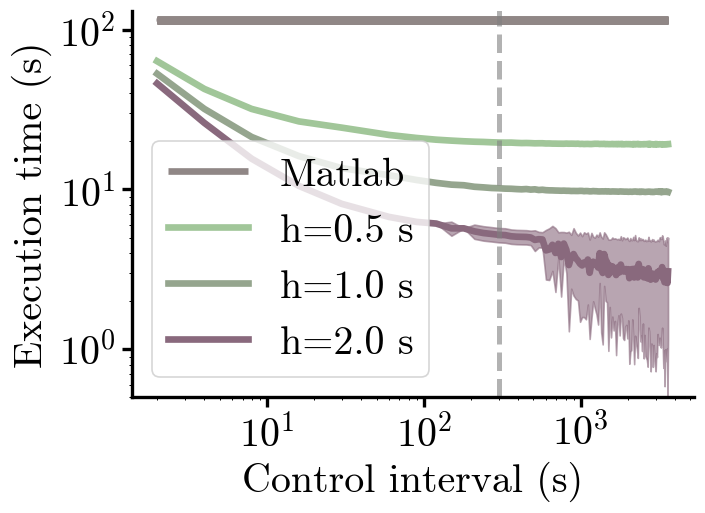

In [47]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot()

colors = [cm.tokyoS(i) for i in range(4,7)]

ax.hlines(matlab_timing, xmin=2, xmax=3600, label="Matlab", linewidth=4, linestyle="-", colors=cm.tokyoS(2), alpha=1.0)
ax.fill_between([2, 3600], matlab_timing_mean - matlab_timing_std, matlab_timing_mean + matlab_timing_std, color=cm.tokyoS(2), alpha=0.6)

for i, df_mean in enumerate(step_size_run_time_mean):
    ax.plot(df_mean['Control frequency'], df_mean['Run time'], linewidth=4, color=colors[i], label=f'h={step_sizes[i]} s')
    ax.fill_between(df_mean['Control frequency'], df_mean['Run time'] - step_size_run_time_std[i]['Run time'], df_mean['Run time'] + step_size_run_time_std[i]['Run time'], color=colors[i], alpha=0.6)

ylim = ax.get_ylim()
ax.vlines(300, 0.5, 200, linestyle="--", linewidth=3, color='grey', alpha=0.6)

ax.set_ylim(0.5, 130)

ax.set_ylabel("Execution time (s)")
ax.set_xlabel("Control interval (s)")
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='lower left')
fig.tight_layout()
fig.savefig("execution_time.svg")
plt.show()


In [8]:
def compute_relative_diff(truth, deviation):
    return (deviation-truth)/truth * 100

In [10]:
df = step_size_run_time_data[1]

# def relative_change_profit(df, )

profit_grouped = df.groupby(['Control frequency', 'episode'])['Profits'].sum().reset_index()

# Filtdf_corrected.set_index('episode', inplace=True)er the DataFrame for control frequency 2.0 for easy reference
# profit_grouped.set_index('episode', inplace=True)

cf_2_corrected = profit_grouped[profit_grouped['Control frequency'] == 2.0]['Profits']

profit_grouped['Relative Change in Profit'] = profit_grouped.apply(
    lambda row: ((row['Profits'] - cf_2_corrected.loc[row['episode']]) / cf_2_corrected.loc[row['episode']]  *100) 
                if row['Control frequency'] != 2.0 else 0, axis=1)


In [11]:
# take the mean of the relative change in profit for each control frequency
relative_change_mean = profit_grouped.groupby('Control frequency')['Relative Change in Profit'].mean()
relative_change_std = profit_grouped.groupby('Control frequency')['Relative Change in Profit'].std()
# relative_change
relative_change_mean

Control frequency
2.0       0.000000
4.0      -0.000662
8.0      -0.002225
16.0     -0.000901
30.0     -0.003678
            ...   
3480.0   -5.460448
3510.0   -5.754128
3540.0   -5.930087
3570.0   -6.529432
3600.0   -6.620819
Name: Relative Change in Profit, Length: 124, dtype: float64

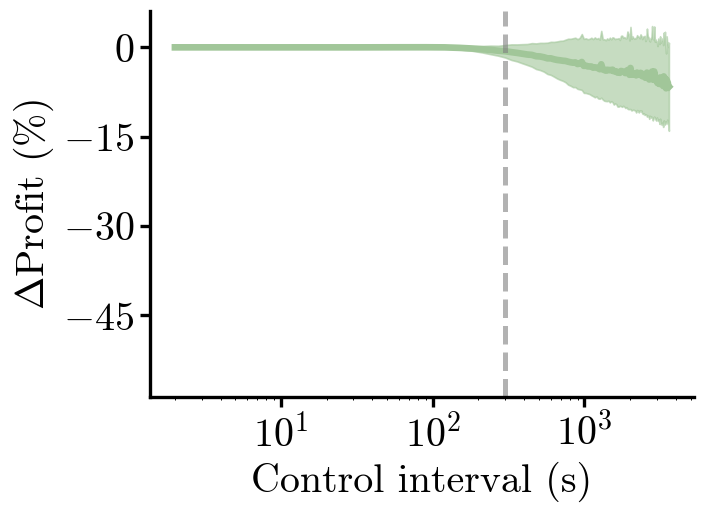

In [56]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[:], relative_change_mean.iloc[:], linewidth=4, color=colors[0])

ax.fill_between(control_frequencies[:], relative_change_mean.iloc[:] - relative_change_std.iloc[:], relative_change_mean.iloc[:] + relative_change_std.iloc[:], color=colors[0], alpha=0.6)

ax.set_ylabel(r"$\Delta$Profit (%)")
ax.set_xlabel("Control interval (s)") 

ax.set_xscale('log')
ylim = (-58.80595347004319, 6.0380082942254525)
# ylim = ax.get_ylim()#[ , ax.get_ylim()[1]]
ax.vlines(300, ylim[0], ylim[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.set_ylim(ylim)

ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.tight_layout()
fig.savefig("delta_profit.svg")
plt.show()


In [ ]:
# steps_per_episode = df.groupby('Control frequency').nunique()


Control frequency
2.0       432000.0
4.0       216000.0
8.0       108000.0
16.0       54000.0
30.0       28800.0
            ...   
3480.0       248.0
3510.0       246.0
3540.0       244.0
3570.0       242.0
3600.0       240.0
Name: episode, Length: 124, dtype: float64

In [24]:
def relative_diff_twb(df, constraint_violation):
    '''
    Compute relative difference between time within boundary for a specific state variable.
    '''


    episode_length_per_control_freq = df[df['episode'] == 1].groupby('Control frequency')['episode'].sum()
    violation_df = df.assign(Violation = df[constraint_violation] >= 0)
    violation_df = violation_df.groupby(['Control frequency', 'episode'])['Violation'].sum().reset_index()
    violation_df['CF_Value'] = violation_df['Control frequency'].map(episode_length_per_control_freq)
    violation_df['TWB'] = violation_df['Violation'] / violation_df['CF_Value'] * 100

    reference_df = violation_df[violation_df['Control frequency'] == 2.0]['TWB']


    violation_df['Relative Change in TWB'] = violation_df.apply(
        lambda row: ((row['TWB'] - reference_df.loc[row['episode']]) / reference_df.loc[row['episode']]  *100) 
                    if row['Control frequency'] != 2.0 else 0, axis=1)



    violation_df_mean = violation_df.groupby('Control frequency', as_index=False)['Relative Change in TWB'].mean()
    violation_df_std = violation_df.groupby('Control frequency', as_index=False)['Relative Change in TWB'].std()

    return violation_df_mean, violation_df_std


In [50]:
df = step_size_run_time_data[1]
violations = ['CO2 violation','Temperature violation', 'Humidity violation']
twb_change = []
twb_change_std = []
for violation in violations:
    df_mean, df_std = relative_diff_twb(df, violation)
    twb_change.append(df_mean)
    twb_change_std.append(df_std)

(-58.80595347004319, 6.0380082942254525)


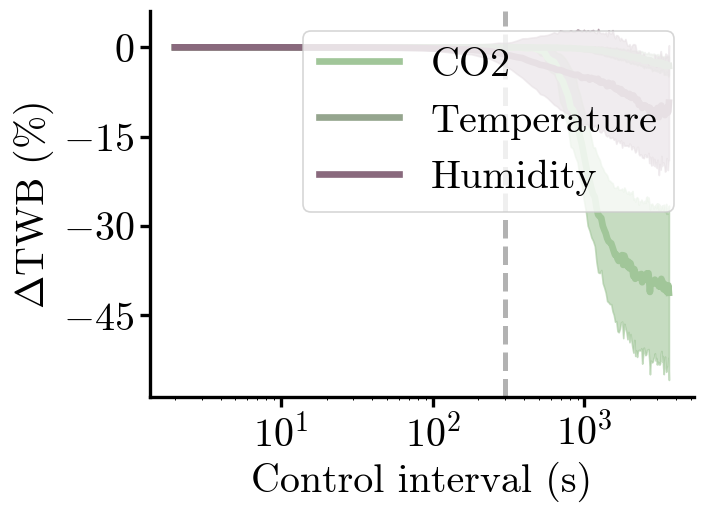

In [55]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
labels= ['CO2','Temperature', 'Humidity']

for i, twb in enumerate(twb_change):
    ax.plot(control_frequencies[:], twb['Relative Change in TWB'].iloc[:], linewidth=4, color=colors[i], label=labels[i])

    ax.fill_between(control_frequencies[:], twb['Relative Change in TWB'].iloc[:] - twb_change_std[i]['Relative Change in TWB'].iloc[:], twb['Relative Change in TWB'].iloc[:] + twb_change_std[i]['Relative Change in TWB'].iloc[:], color=colors[i], alpha=0.6)

    # ax.fill_between(control_frequencies[:], twb['Relative Change in TWB'].iloc[1:] - Relative Change in TWB_change_std[i]['Relative Change in TWB'].iloc[1:], Relative Change in TWB['Relative Change in TWB'].iloc[1:] + Relative Change in TWB_change_std[i]['Relative Change in TWB'].iloc[1:], color=colors[i], alpha=0.6)

ylim = ax.get_ylim()
ax.vlines(300, ylim[0], ylim[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.set_ylim(ylim)
print(ylim)
ax.set_ylabel(r"$\Delta$TWB (%)")
ax.set_xlabel("Control interval (s)") 

ax.set_xscale('log')
ylim = [-9 , ax.get_ylim()[1]]
ax.legend()
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.tight_layout()
fig.savefig("delta_twb.svg")
plt.show()

In [ ]:
# def compute_daily_resource(python_states):
#     co2_resource = np.zeros(shape=(len(python_states), ))
#     gas_resource = np.zeros(shape=(len(python_states), ))
#     electric_resource = np.zeros(shape=(len(python_states), ))
#     heat_demands = np.zeros(shape=(len(python_states), ))
#     fruit_harvest = np.zeros(shape=(len(python_states), ))
#     for i, control_freq_df in enumerate(python_states):
#         co2_resource[i] += sum(control_freq_df["co2_resource"].iloc[1:])/10
#         gas_resource[i] += sum(control_freq_df["gas_resource"].iloc[1:])/10
#         electric_resource[i] += sum(control_freq_df["electrical_resource"].iloc[1:] * control_frequencies[i]) * 1e-6/10
#         heat_demands[i] += sum(control_freq_df["heat_demand"].iloc[1:] * control_frequencies[i]) * 1e-6/10
#         fruit_harvest[i] += sum(control_freq_df["fruit_harvest"].iloc[1:])/10
#     return co2_resource, gas_resource, electric_resource, heat_demands, fruit_harvest

In [ ]:
# co2_resource, gas_resource, electric_resource, heat_demands, fruit_harvest = compute_daily_resource(python_states)
# profits = compute_profit(fruit_harvest, co2_resource, gas_resource, dmfm, tom_price, gas_price, co2_price)


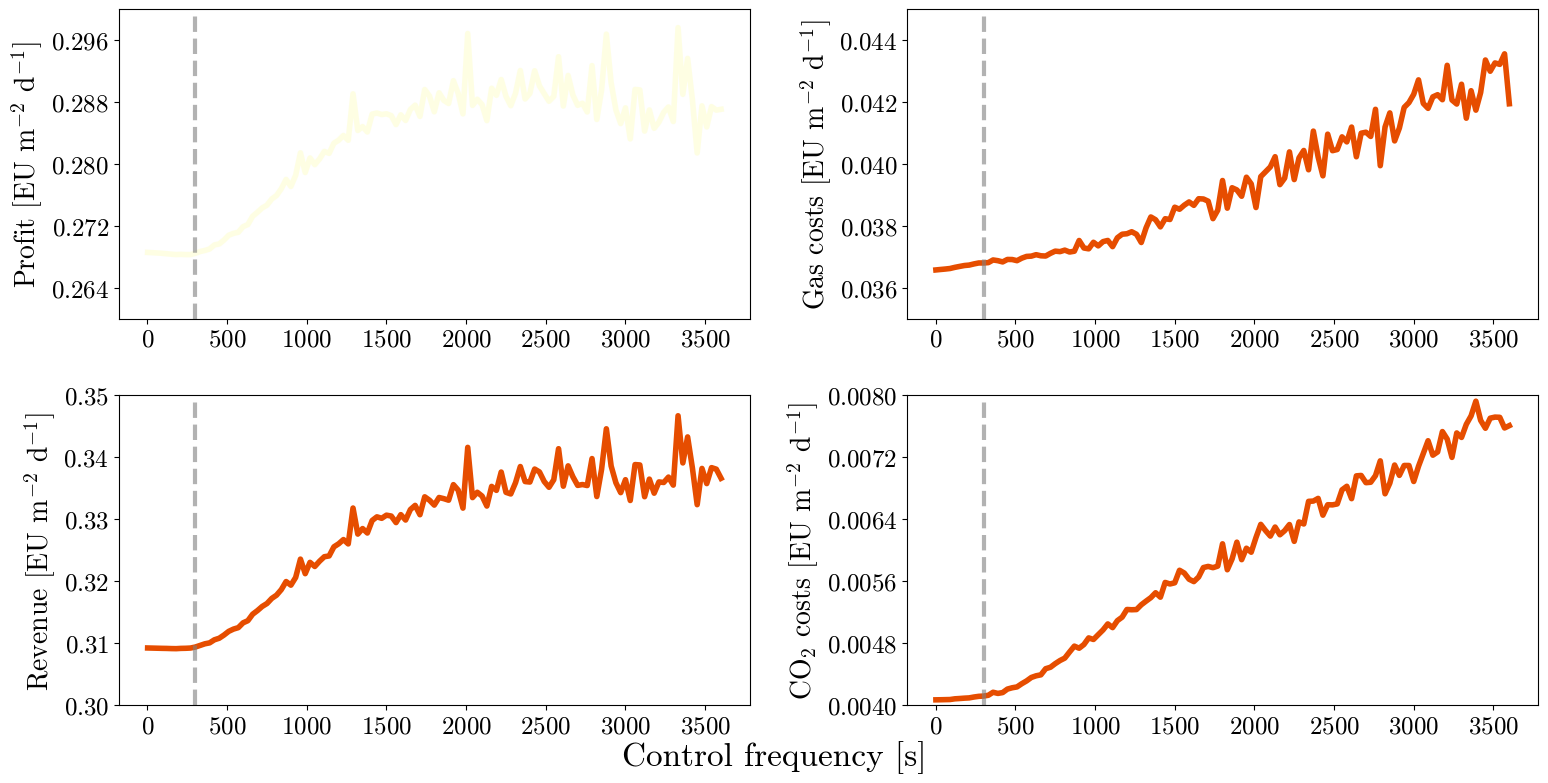

In [ ]:
fig = plt.figure(figsize=(16,8))
c = cm.tokyoS
ax = fig.add_subplot(221)
ax.plot(control_frequencies, profits, linewidth=4, color=c(1), alpha=.7)
ax.set_ylabel(r"Profit [EU m$^{-2}$ d$^{-1}$]")
ax.set_ylim(0.26, .3)
ax.vlines(300, 0.26, .3, linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax = fig.add_subplot(222)
ax.plot(control_frequencies, gas_resource*gas_price, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"Gas costs [EU m$^{-2}$ d$^{-1}$]")
ax.set_ylim(.035, .045)
ax.vlines(300, .035, .045, linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax = fig.add_subplot(223)
ax.plot(control_frequencies, fruit_harvest/dmfm*tom_price, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"Revenue [EU m$^{-2}$ d$^{-1}$]")
ax.set_ylim(0.3, 0.35)
ax.vlines(300, 0.3, 0.35, linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax = fig.add_subplot(224)
ax.plot(control_frequencies, co2_resource*co2_price, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"CO$_2$ costs [EU m$^{-2}$ d$^{-1}$]")
ax.set_ylim(.004, .008)
ax.vlines(300, .004, .008, linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))



# ax = fig.add_subplot(224)
# ax.hlines(matlab_timing, xmin=1, xmax=3600, label="Matlab", linewidth=4, linestyle="--", colors=(0,0,0), alpha=0.7)
# ax.plot(time_frequencies, execution_times.values[0,:], linewidth=4, color=(0.9, 0.3, 0), label="GreenLight-Gym")
# ax.set_ylabel("Execution time [s]")

# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.legend(loc='lower left')

fig.text(0.5, 0.01, "Control frequency [s]", ha="center")
fig.tight_layout()
fig.savefig('effect_control_freq.svg')
plt.show()

In [ ]:
profit_decay = compute_relative_diff(profits)
gas_decay = compute_relative_diff(gas_resource*gas_price)
revenue_decay = compute_relative_diff(fruit_harvest/dmfm*tom_price)
co2_decay = compute_relative_diff(co2_resource*co2_price)



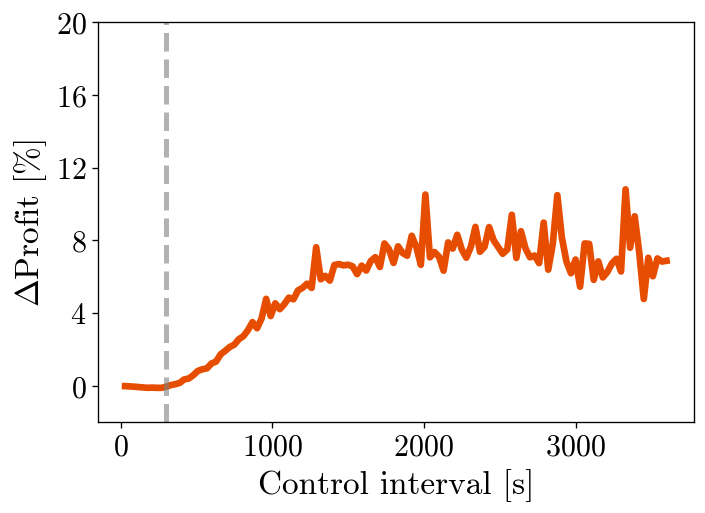

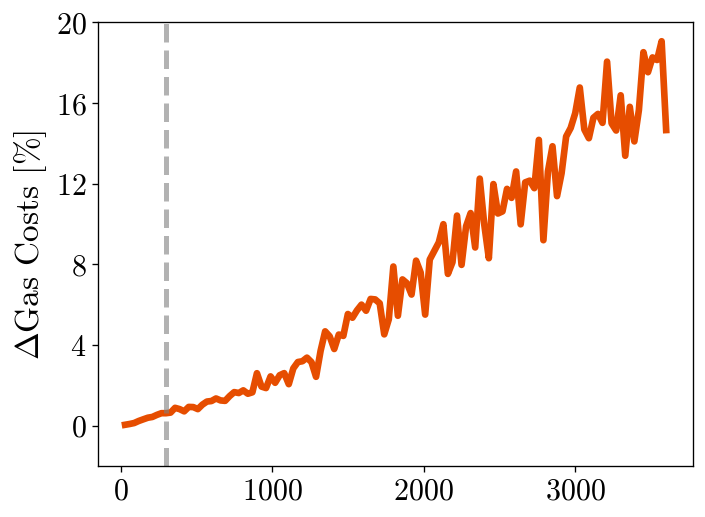

In [81]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[1:], gas_decay, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"$\Delta$Gas Costs [%]")
ax.set_ylim(-2, 20)
ax.vlines(300, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.savefig("delta_gas.svg")
plt.show()

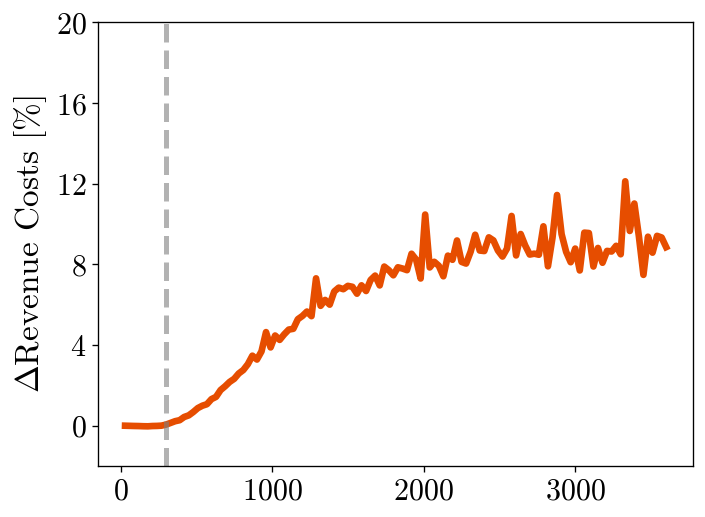

In [82]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[1:], revenue_decay, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"$\Delta$Revenue Costs [%]")
ax.set_ylim(-2, 20)
ax.vlines(300, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.savefig("delta_revenue.svg")

plt.show()

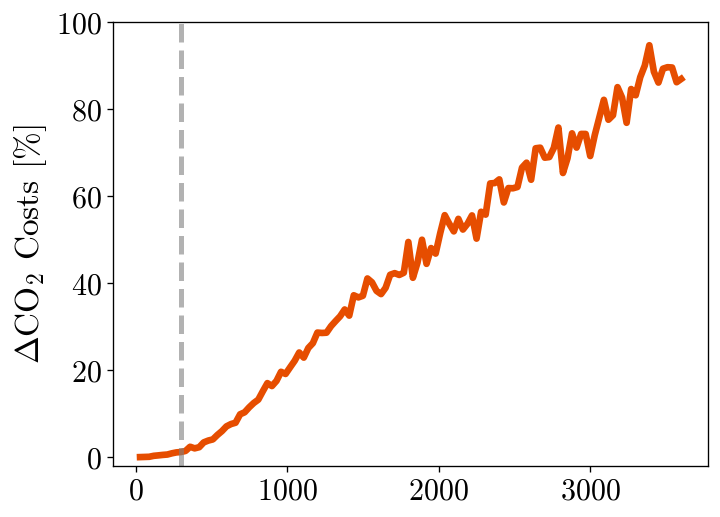

In [83]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[1:], co2_decay, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"$\Delta$CO$_2$ Costs [%]")
ax.set_ylim(-2, 100)
ax.vlines(300, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
fig.savefig("delta_co2.svg")

plt.show()

In [ ]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[1:], gas_decay, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"$\Delta$Gas costs [%]")
ax.set_ylim(-2, 20)
ax.vlines(300, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
plt.show()

In [ ]:
fig = plt.figure(dpi=120)

ax = fig.add_subplot()
ax.plot(control_frequencies[1:], profit_decay, linewidth=4, color=(0.9, 0.3, 0))
ax.set_ylabel(r"$\Delta$Profit [%]")
ax.set_ylim(-2, 11)
ax.vlines(300, ax.get_ylim()[0], ax.get_ylim()[1], linestyle="--", linewidth=3, color='grey', alpha=0.6)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
plt.show()

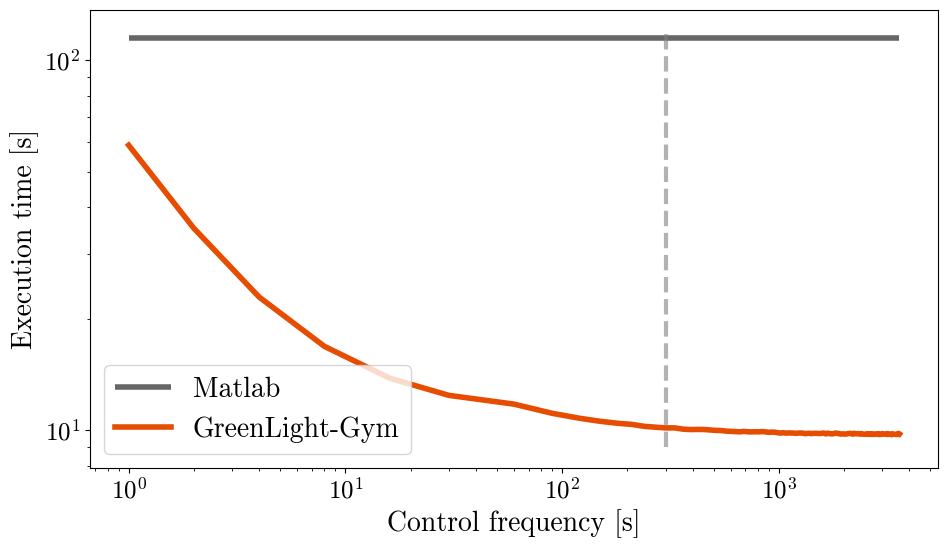

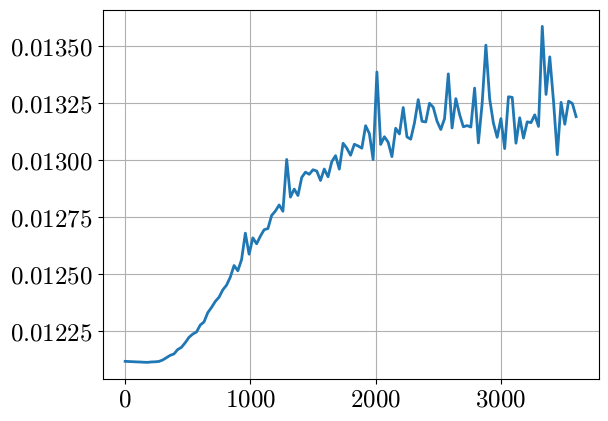

In [352]:
plt.plot(control_frequencies, fruit_harvest, linewidth=2)


(0.0, 0.1)

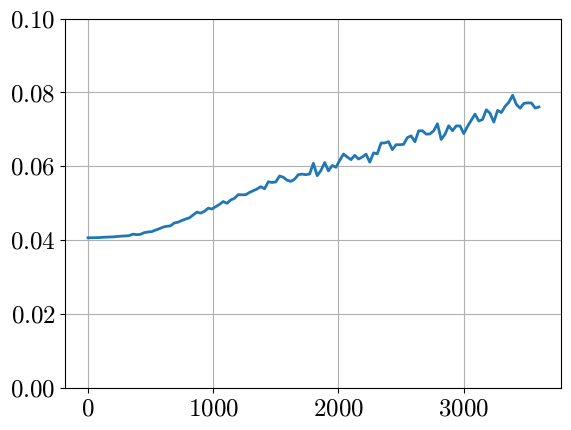

In [61]:
plt.plot(control_frequencies, co2_resource, linewidth=2)
plt.ylim(0,0.1)
# plt.vlines(900, ymin=0.4, ymax=1.3, linestyles="--", colors='black', alpha=0.5, linewidth=3)
# plt.vlines(300, ymin=0.4, ymax=1.3, linestyles="--", colors='black', alpha=0.5, linewidth=3)

# plt.xscale("log")

In [36]:
python_states["Time [s]"].diff().iloc[1:]*py_states["heat_demand"].iloc[1:].sum()

1      3.792826e+07
2      3.792826e+07
3      3.792826e+07
4      3.792826e+07
5      3.792826e+07
           ...     
236    3.792826e+07
237    3.792826e+07
238    3.792826e+07
239    3.792826e+07
240    3.792826e+07
Name: Time [s], Length: 240, dtype: float64

In [11]:
matlab_states.shape, python_states.shape

((960, 28), (961, 29))

In [24]:
python_controls["uBoil"].mean()

python_controls["uCO2"].mean()

0.10692813281517512

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


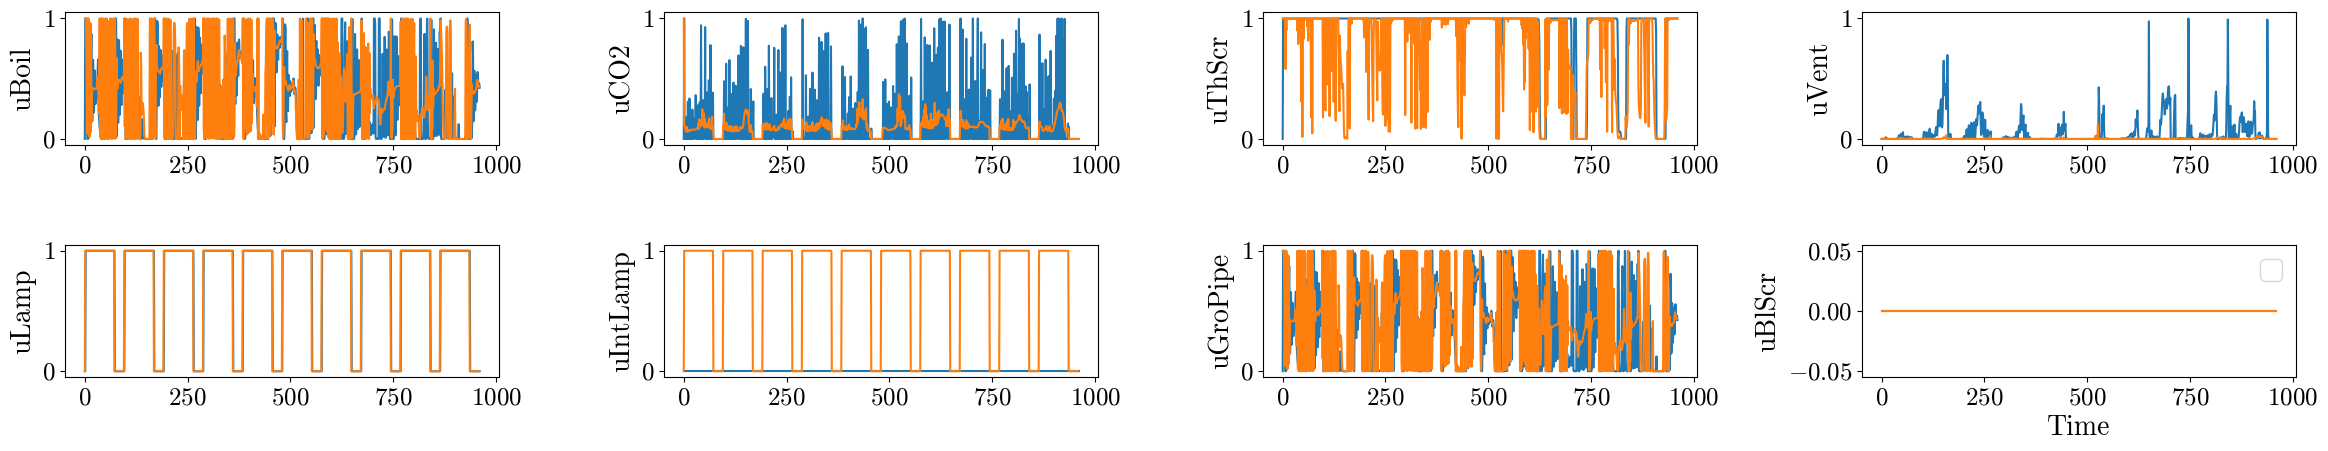

In [14]:
fig = plt.figure(figsize=(24, 16))
for i, col in enumerate(python_controls.columns[:]):
    ax = fig.add_subplot(7, 4, i+1)
    ax.plot(python_controls[col])
    ax.plot(matlab_controls[col])
    # ax.plot(python_controls[col])
    # ax.plot(matlab_controls[col])

    ax.set_ylabel(col)
ax.set_xlabel("Time")
ax.legend()
fig.tight_layout()
plt.show()

In [15]:
def rRMSE(predictions, truth):
    return np.sqrt(np.sum((truth-predictions)**2)/truth.shape[0])/abs(truth.mean())*100


In [ ]:
# cols = ["uBoil", "uCO2", "uThScr", "uVent", "uLamp"]

# fig = plt.figure(dpi=120)
# ax = fig.add_subplot(111)
# ax.bar(cols, control_rRMSEs[cols])
# # ax.bar(matlab_states.columns[:-1], rRMSEs)
# ax.tick_params(axis='x', labelrotation=90)
# ax.set_ylabel("Relative RMSE")
# plt.show()

In [27]:
rRMSEs = []
RMSEs = []
for col in matlab_states.columns[:-1]:
    rRMSEs.append(rRMSE(python_states[col].iloc[:-1], matlab_states[col]))
    # RMSEs.append(RMSE(python_states[col].iloc[:-1], matlab_states[col]))

rRMSEs = pd.Series(data=rRMSEs, index=matlab_states.columns[:-1])
# RMSEs = pd.Series(data=RMSEs, index=matlab_states.columns[:-1])

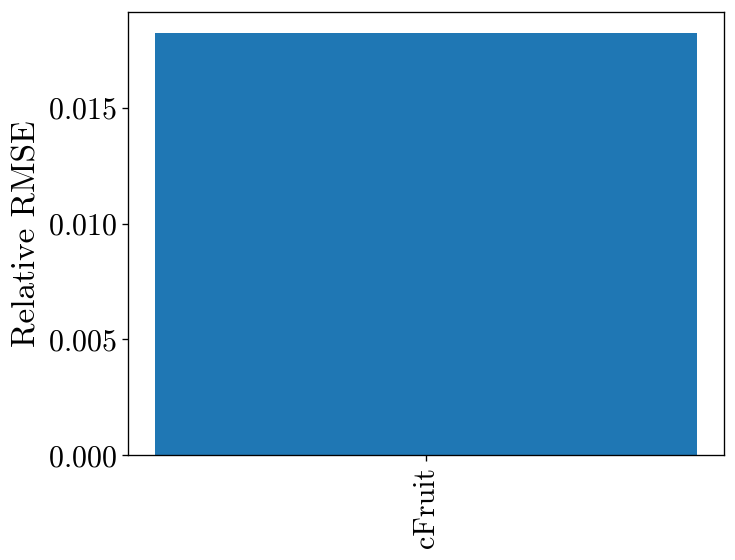

In [25]:
cols = ["cFruit"]

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.bar(cols, rRMSEs[cols])
# ax.bar(matlab_states.columns[:-1], rRMSEs)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Relative RMSE")
plt.show()


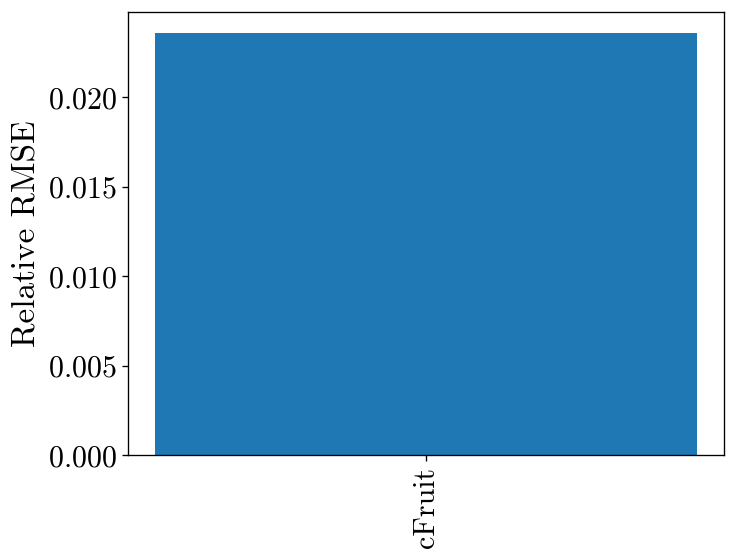

In [28]:
cols = ["cFruit"]

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.bar(cols, rRMSEs[cols])
# ax.bar(matlab_states.columns[:-1], rRMSEs)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Relative RMSE")
plt.show()


In [ ]:
cols = ["tAir", "co2Air", "vpAir", "cFruit"]

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)
ax.bar(cols, rRMSEs[cols])
# ax.bar(matlab_states.columns[:-1], rRMSEs)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("Relative RMSE")
plt.show()